# Approximate Nearest Neighbors:

# Image Recommendation System via Collaborative Filtering

# ***Please read the instructions very carefully***
This is a modified version of the previous question and requires you to use an artificial nearest neighbors library

We suggest you to use one of the following:
- [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy.git)

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   ⚠️ The Assignment will be evaluated automatically. Please adhere to taking proper inputs from `config.csv` file. You can change your `config.csv` file to experiment with your code. But at the end, make sure that your outputs are corresponding to input values in `config.csv`
5.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

## About the Dataset
Behance is a community art website where users showcase and discover creative work. Each user is able to “appreciate” (equivalent to a “like” on Instagram or a “react” on Facebook) an image, indicating that they like the image. It is in the website’s best interests to show users pictures that they would like, to keep them engaged for longer. For this question, given a set of pictures that a user has already appreciated, you have to show them a new picture that they would like based on what similar users appreciated.


<br><br>
**The dataset has information of 1 million appreciates of 63,497 users on 178,788 items. The file Behance appreciate 1M has a triplet in each line in the form of (user id, item id, unix timestamp).**

**Task: Take the inputs from the config.csv file and output the recommendations for a particular person**
- Collaborative Filtering is a way to predict items to the user based on the the
user’s history and the history of similar users. The similarity between users can be quantified by the number of images that both the users appreciated.
- The images appreciated by a similar user would be the most suitable images to show a user. Since we can find the similarity between any two users, we would be able to find the “nearest” neighbours of any user, allowing us to use a KNN-based algorithm to recommend new images to a user.
- Since people do not like seeing pictures that they have seen already. Make sure that you do not recommend pictures that a user has appreciated already.
- Output the final response will be saved in the file named ```config['output_file']```.


**Output file format:**
Populate the output file with images that the user has not seen of the k most
similar users, in descending order of their similarity. Each line in the output
file should be a duplet in the form of (item id, user id), where the user id is the
id of the kth similar user. The order of the images corresponding to the same
similar user would not matter. The output file would look something like this:
```
item_id_1_of_1st_similar_user 1st_most_similar_user_id
item_id_2_of_1st_similar_user 1st_most_similar_user_id
item_id_3_of_1st_similar_user 1st_most_similar_user_id
...
item_id_1_of_2nd_similar_user 2nd_most_similar_user_id
item_id_2_of_2nd_similar_user 2nd_most_similar_user_id
item_id_3_of_2nd_similar_user 2nd_most_similar_user_id
...
item_id_1_of_kth_similar_user kth_most_similar_user_id
item_id_2_of_kth_similar_user kth_most_similar_user_id
item_id_3_of_kth_similar_user kth_most_similar_user_id
```

You may use any other recommendation system that you wish to use. However,
evaluation script will score your submission by measuring the similarity between
users with the number of common images they appreciated.
The dataset was extracted using Behance’s API as a part of the paper
“Vista: A visually, socially, and temporally-aware model for artistic
recommendation, RecSys, 2016”. Check out this [Google Drive folder](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA) for
more information about the dataset.


Have fun! The users are waiting to see new pictures!

### Import necessary libraries

In [2]:
pip install scann

     |████████████████████████████████| 10.6 MB 12.0 MB/s 


In [71]:
import scann
import numpy as np
import math
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import norm

In [34]:
# Config Generation Sample Code.
# ⚠️ Only for experimentation on your side.
# ⚠️ Should be commented during submission.

# df = pd.DataFrame(data=[{'id':276633,
#                   'k':5,
#                   'dataset_file':'./Behance_appreciate_1M',
#                   'output_file':'./output.txt'}])
# df.to_csv('config.csv')

In [35]:
config = pd.read_csv('config.csv').iloc[0]

In [36]:
config

Unnamed: 0                            0
id                               276633
k                                     5
dataset_file    ./Behance_appreciate_1M
output_file                ./output.txt
Name: 0, dtype: object

In [37]:
user = config['id']
k_value = config['k']

### Read the Data

In [38]:
with open(config['dataset_file'], 'r') as inFile:
    appreciate_data = inFile.readlines()

### Initialize a dictionary to store the item_ids that a user likes

### Go through each line of the input file and construct the user_likes dictionary

In [39]:
user_likes = dict()

In [40]:
for line in appreciate_data:
    line = line.strip()
    
    user_id = int(line.split()[0])
    item_id = int(line.split()[1])

    if user_id not in user_likes:
        user_likes[user_id] = list()
    
    user_likes[user_id].append(item_id)

In [41]:
list_of_users = []

In [42]:
set_of_users = []
set_of_images = []

for i in user_likes:
    set_of_users.append(i)
set_of_users = set(set_of_users)
print(len(set_of_users))

for i in user_likes.values():
    for j in i:
        set_of_images.append(j)

set_of_images = set(set_of_images)
print(len(set_of_images))

count = 0
index_of_image = {}
for i in set_of_images:
    index_of_image[i] = count
    count = count + 1

count = 0
index_of_user = {}
for i in set_of_users:
    index_of_user[i] = count
    count = count + 1    

63497
178788


In [43]:
row = []
col = []
data = []
for i in set_of_users:
    for j in user_likes[i]:
        row.append(index_of_user[i])
        col.append(index_of_image[j])
        data.append(1)
    list_of_users.append(i)

In [44]:
mat = csr_matrix((data, (row,col)))

In [45]:
svd = TruncatedSVD(n_components=1500, n_iter=5, random_state=10)
mat = svd.fit_transform(mat)

In [68]:
number_of_user = len(appreciate_data)

In [46]:
mat = mat / np.linalg.norm(mat, axis=1)[:, np.newaxis]

In [72]:
searcher = scann.scann_ops_pybind.builder(mat, 10, "dot_product").tree(
    num_leaves=math.ceil(np.sqrt(number_of_user)), num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

### Use your choice of Approximate Nearest Neigbor after Collaborative Filtering to find nearest neighbors

In [73]:
# your code here
def neighbors(user,k_value):
    neighbors, distances = searcher.search(mat[index_of_user[user]], final_num_neighbors=k_value+50)
    # print(neighbors,distances)
    set1 = set(user_likes[user])
    ans = []
    for i in neighbors:
      set2 = set(user_likes[list_of_users[i]])
      if len(set2 - set1) != 0:
        ans.append(list_of_users[i])
      if len(ans)==k_value:
        break
    return ans

### Answer the following questions:

#### Q1. **Explain how your choice of library works**

**ScaNN**

ScaNN stands for Scalable Nearest Neighbors. It is a method for searching the vector similarity at high scale effeciently. ScaNN algorithm is used in Vertex Matching Engine (GCP), which is a managed similarity search service. ScaNN is vector quantization algorithm for maximum inner product search.The algorithm is a combination of product quantization, score aware loss and anisotropic loss.Quantization error can be decomposed to parallel component and orthogonal component. And the parallel component penalizes more than the orthogonal component.Standard vector quantization is not very practical for high dimensional or large scale databases. PQ (product quantization) is a widely used scalable vector quantization method. In the standard vector quantization, a code book is generated from original vectors. On the other hand, PQ divides vectors into multiple subspaces and for each subspace a code book is generated. This approach allows to handle high dimensional vectors and large scale databases. 


#### Q2. **Compare your choice of library with vanilla KNN.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

The Time Complexity for the knn I have used is **O(n*d)** where n is number of traning points and d is dimensions of the vector. In terms of processing speed ScaNN is way faster than our vanilla knn or the inbuilt sklearn knn.



#### Q3. **Compare your choice of library with implementation of ScaNN, faiss and annoy.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

Out of 3 libraries given, i have used ScaNN for the recommending the images to the user. I have chosen Scann as it the fasttest algorithm among all the three mentioned. We can from the graph below that at around 98% accuracy ScaNN is approximately 4 times faster than Annoy and Faiss.

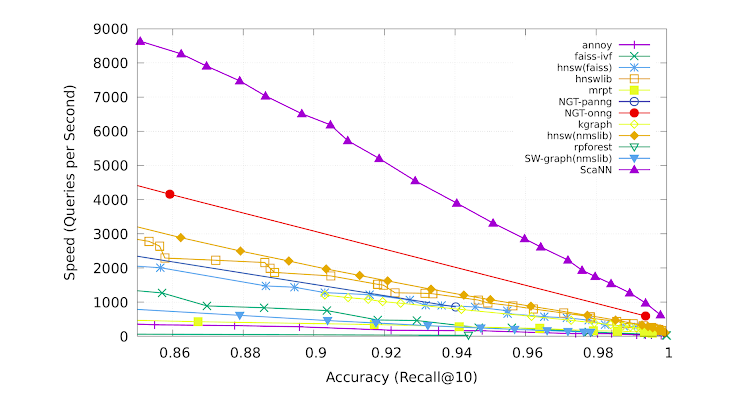

### Open the output file to write all the lines to the file

In [74]:
outFile = open(config['output_file'], 'w')
l = neighbors(user,k_value)
print(l)
image_set = set(user_likes[user])
for n_user in l:
    user_id = n_user
    for item_id in user_likes[user_id]:
      if item_id not in image_set:
        outFile.write(str(item_id) + ' ' + str(user_id) + '\n')

outFile.close()

[2452817, 1525134, 1999429, 587857, 1640984]
